# Lesson 7 - Parkinson PCR

## Author - Matthew Denko

### Description:

Perform Principal Component Regression on a <a href="https://archive.ics.uci.edu/ml/datasets/parkinsons+telemonitoring">dataset that tracked patients with Parkinson's Disease</a>.

Citation: A Tsanas, MA Little, PE McSharry, LO Ramig (2009)
'Accurate telemonitoring of Parkinson's disease progression by non-invasive speech tests',
IEEE Transactions on Biomedical Engineering.

About the data:
This dataset is composed of a range of biomedical voice measurements from 42 people with early-stage Parkinson's disease recruited to a six-month trial of a telemonitoring device for remote symptom progression monitoring. The recordings were automatically captured in the patient's homes.

#### Instructions:

 1. Load the dataset.
 2. Create the X-matrix (one-hot encoding categorical factors).
 3. Scale the X-matrix.
 4. Create the principal components and do a simple plot of the explained variance.
 5. PCR - Linear regression with the principal components.

Report on:

 1. Number of components before and after (choose a smaller number of principal components and explain how you chose them).
 2. Interpret the adjusted R-squared.

# 1. Load the dataset

In [1]:
filename = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data"

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns

In [3]:
parkinsons_df = pd.read_csv(filename)
parkinsons_df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [4]:
parkinsons_df.columns

Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')

# 2. Create the X-matrix (one-hot encoding categorical factors).

In [5]:
# Define the target and features:
target_label = 'total_UPDRS'
non_features = ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS']
feature_labels = [x for x in parkinsons_df.columns if x not in [target_label] + non_features]

# Filter out non-features and non-targets
parkinsons_df = parkinsons_df.drop(non_features, axis=1)

# One-hot encode inputs
parkinsons_expanded = pd.get_dummies(parkinsons_df, drop_first=True)
print('DataFrame one-hot-expanded shape: {}'.format(parkinsons_expanded.shape))

# Get target and original x-matrix
y = parkinsons_df[target_label]
x = parkinsons_df.as_matrix(columns=feature_labels)

DataFrame one-hot-expanded shape: (5875, 17)


/Users/matt.denko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


# 3. Scale the X-matrix.

In [6]:
# Scale function
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

In [7]:
# Scale all columns first

# Create x-scaled

x_scaled = np.apply_along_axis(scale, 0, x)
print(x_scaled)

# Create a scaled y-target.

y_scaled = np.apply_along_axis(scale, 0, y)
print(y_scaled)

[[ 0.08290524 -0.28424219  0.32745251 ... -1.21406557 -1.47849968
  -0.65065821]
 [-0.56079341 -0.75672302 -0.53374622 ... -1.05511879 -1.24788006
  -1.21858474]
 [-0.23894409 -0.53938184 -0.30003802 ... -0.78485974 -1.5401393
  -0.10328021]
 ...
 [-0.47366293 -0.5371584  -0.46971658 ... -0.62937908 -1.04885603
  -0.85275524]
 [-0.5945787  -0.65833584 -0.54655215 ...  0.26914065 -1.26903782
  -0.8476181 ]
 [-0.59280052 -0.63721316 -0.52414178 ...  0.44175389 -1.163249
  -0.72388969]]
[0.50274516 0.54910301 0.59536741 ... 0.32488426 0.27927411 0.23310318]


## Comments:

    Both the x values and y target values have been scaled. This is a necessary step before creating the principal components.

# 4. Create the principal components and do a simple plot of the explained variance.

In [8]:
# PCA

pca = PCA(n_components=16)
pca_result = pca.fit_transform(x_scaled)

column_names = ['pc' + str(ix+1) for ix in range(x_scaled.shape[1])]
pca_df = pd.DataFrame(data = pca_result, columns=column_names)
pca_df[target_label] = y_scaled

Text(0,0.5,'Explained Variance')

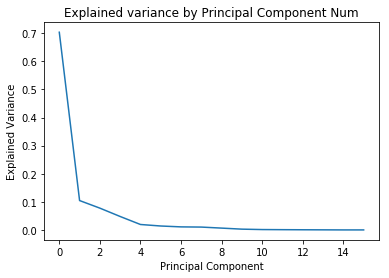

In [9]:
# Plot the explained variance for all principal components.

plt.plot(pca.explained_variance_ratio_)
plt.title('Explained variance by Principal Component Num')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')

## Comments:

    The first component explains 70% of the variance in the model. The remining components explain the remaining %30 of the model.

# 5. PCR - Linear regression with the principal components.

                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     40.94
Date:                Sun, 10 Mar 2019   Prob (F-statistic):          5.85e-122
Time:                        17:57:23   Log-Likelihood:                -8024.9
No. Observations:                5875   AIC:                         1.608e+04
Df Residuals:                    5858   BIC:                         1.620e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.553e-16      0.012   1.25e-14      1.0

/Users/matt.denko/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/matt.denko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Residual Histogram')

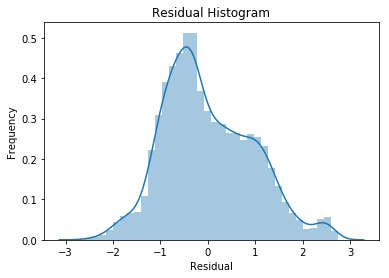

In [10]:
# All 16 components

# Perform linear regression with the first N columns.
n = 16
formula_start = target_label + ' ~ '
formula_terms = ['pc' + str(x+1) for x in range(n)]
formula_end = ' + '.join(formula_terms)
formula_final = formula_start + formula_end

pcr_model = sm.ols(formula = formula_final, data=pca_df)

results = pcr_model.fit()

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

## Comments:
    
    For the first regression I used all 16 components of the model. The adjusted R Squared value when including all 16 components in the regression model is .098. The adjusted R Squared value is similar to the R square value however it penalizes a model for adding features that do improve the model. To examine how many features should be included I will re-run the analysis using lesser compents.

                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     64.74
Date:                Sun, 10 Mar 2019   Prob (F-statistic):          1.40e-125
Time:                        17:57:28   Log-Likelihood:                -8028.7
No. Observations:                5875   AIC:                         1.608e+04
Df Residuals:                    5864   BIC:                         1.615e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.553e-16      0.012   1.25e-14      1.0

/Users/matt.denko/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/matt.denko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Residual Histogram')

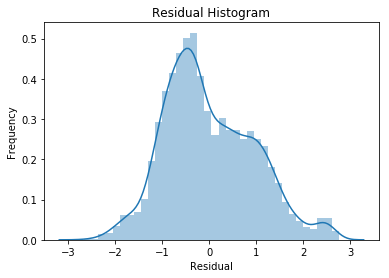

In [11]:
# 10 Components

# Perform linear regression with the first N columns.
n = 10
formula_start = target_label + ' ~ '
formula_terms = ['pc' + str(x+1) for x in range(n)]
formula_end = ' + '.join(formula_terms)
formula_final = formula_start + formula_end

pcr_model = sm.ols(formula = formula_final, data=pca_df)

results = pcr_model.fit()

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

## Comments:
    
    This time I ran the regression with only 10 components and the adjusted R Square value remained the same at .098. I will re-run with 5 components and see if this makes any difference.

                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     95.87
Date:                Sun, 10 Mar 2019   Prob (F-statistic):           2.21e-97
Time:                        17:57:30   Log-Likelihood:                -8105.6
No. Observations:                5875   AIC:                         1.622e+04
Df Residuals:                    5869   BIC:                         1.626e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.553e-16      0.013   1.24e-14      1.0

/Users/matt.denko/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/matt.denko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Residual Histogram')

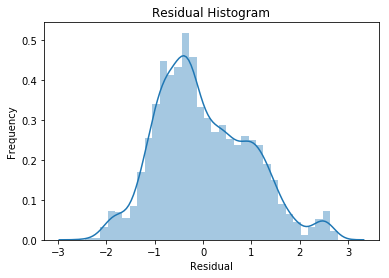

In [12]:
# 5 Components

# Perform linear regression with the first N columns.
n = 5
formula_start = target_label + ' ~ '
formula_terms = ['pc' + str(x+1) for x in range(n)]
formula_end = ' + '.join(formula_terms)
formula_final = formula_start + formula_end

pcr_model = sm.ols(formula = formula_final, data=pca_df)

results = pcr_model.fit()

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

## Comments:
    
    This time I ran the regression with only 5 components and the adjusted R Squared value dropped to .076. I will re-run it with 9 to see if that has a higher or lower adjusted R Squared value

                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     71.84
Date:                Sun, 10 Mar 2019   Prob (F-statistic):          2.42e-126
Time:                        17:57:33   Log-Likelihood:                -8029.1
No. Observations:                5875   AIC:                         1.608e+04
Df Residuals:                    5865   BIC:                         1.614e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.553e-16      0.012   1.25e-14      1.0

/Users/matt.denko/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/matt.denko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Residual Histogram')

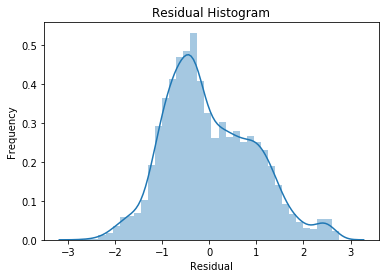

In [13]:
# 9 Components

# Perform linear regression with the first N columns.
n = 9
formula_start = target_label + ' ~ '
formula_terms = ['pc' + str(x+1) for x in range(n)]
formula_end = ' + '.join(formula_terms)
formula_final = formula_start + formula_end

pcr_model = sm.ols(formula = formula_final, data=pca_df)

results = pcr_model.fit()

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     77.63
Date:                Sun, 10 Mar 2019   Prob (F-statistic):          2.43e-122
Time:                        17:57:34   Log-Likelihood:                -8040.6
No. Observations:                5875   AIC:                         1.610e+04
Df Residuals:                    5866   BIC:                         1.616e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.553e-16      0.012   1.25e-14      1.0

/Users/matt.denko/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/matt.denko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Residual Histogram')

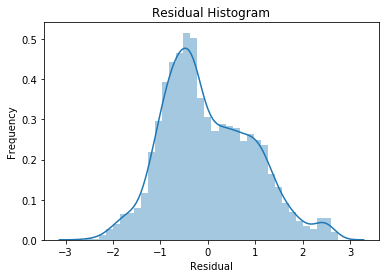

In [14]:
# 8 Components

# Perform linear regression with the first N columns.
n = 8
formula_start = target_label + ' ~ '
formula_terms = ['pc' + str(x+1) for x in range(n)]
formula_end = ' + '.join(formula_terms)
formula_final = formula_start + formula_end

pcr_model = sm.ols(formula = formula_final, data=pca_df)

results = pcr_model.fit()

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

## Comments:

    After running the regression wiht 9 and 8 features it appears that 9 is the lowest number of features that maximizes the adjusted R Squared. I started out with 16 features and will only include 9 in my final model based off the change in adjusted R Squared.